In [1]:
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
N = 20
xMin = -2.0
xMax = 2.0
noizeScale = 0.5

w1 = 1.0
w2 = 0.5

random.seed(5)

w1Min = -3.0
w1Max = 3.0
w2Min = -3.0
w2Max  = 3.0
wStep = 0.05

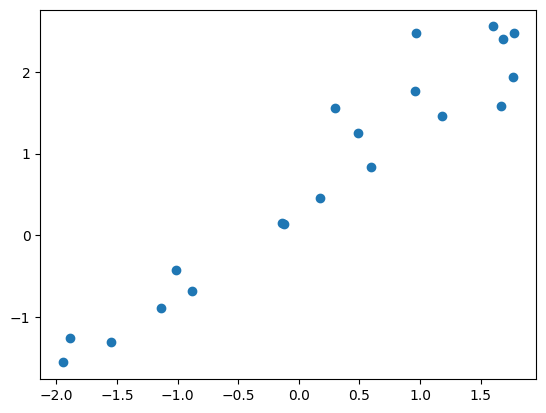

In [3]:
# Make points
xs = np.array([(xMax - xMin) * random.random() + xMin for i in range(N)])
yTmps = (w1 * xs + w2)
noizes = np.random.normal(0, noizeScale, N)
ys = yTmps + noizes

plt.scatter(xs, ys)
plt.show()

In [4]:
# Error functions
def getDiff(xs, ys, ws):
    ones = np.ones(xs.size)
    
    xsArray = np.array([xs, ones])
    theoriticalVals = np.matmul(ws, xsArray)

    diffs = ys - theoriticalVals

    return diffs

def errorMSE(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    mul = np.multiply(diffs, diffs)
    dot = np.sum(mul, axis = 2)

    return dot / xs.size

def errorMAE(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    return np.sum(np.abs(diffs),axis=2) / xs.size

def errorME(xs, ys, ws):
    diffs = getDiff(xs, ys, ws)

    return np.max(np.abs(diffs), axis = 2)

"""
ws = [1.0, 0.5]
print(errorMSE(xs, ys, ws))
print(errorMAE(xs, ys, ws))
print(errorME(xs, ys, ws))
"""

'\nws = [1.0, 0.5]\nprint(errorMSE(xs, ys, ws))\nprint(errorMAE(xs, ys, ws))\nprint(errorME(xs, ys, ws))\n'

In [5]:
def displayError(xs, ys, errorFunc):
    w1s = np.arange(w1Min, w1Max, wStep)
    w2s = np.arange(w2Min, w2Max, wStep)

    W1, W2 = np.meshgrid(w1s, w2s)
    errors = errorFunc(xs, ys, np.array([W1, W2]).transpose(1, 2, 0))

    plt.pcolormesh(W1, W2, errors, cmap = 'prism')

    pp=plt.colorbar (orientation="vertical")

    plt.xlabel('w1', fontsize=10)
    plt.ylabel('w2', fontsize=10)


In [6]:
# Least squares methods
dataNum = xs.size

# (1.6)
xsArray = np.array(xs)
ysArray = np.array(ys)
xy = np.dot(xsArray, ysArray)
xSum = np.sum(xsArray)
ySum = np.sum(ysArray)
xdot = np.dot(xsArray, xsArray)
w1 = (dataNum * xy - xSum *ySum) / (dataNum * xdot - xSum**2)
# (1.7)
w2 = (ySum - w1 * xSum) / dataNum

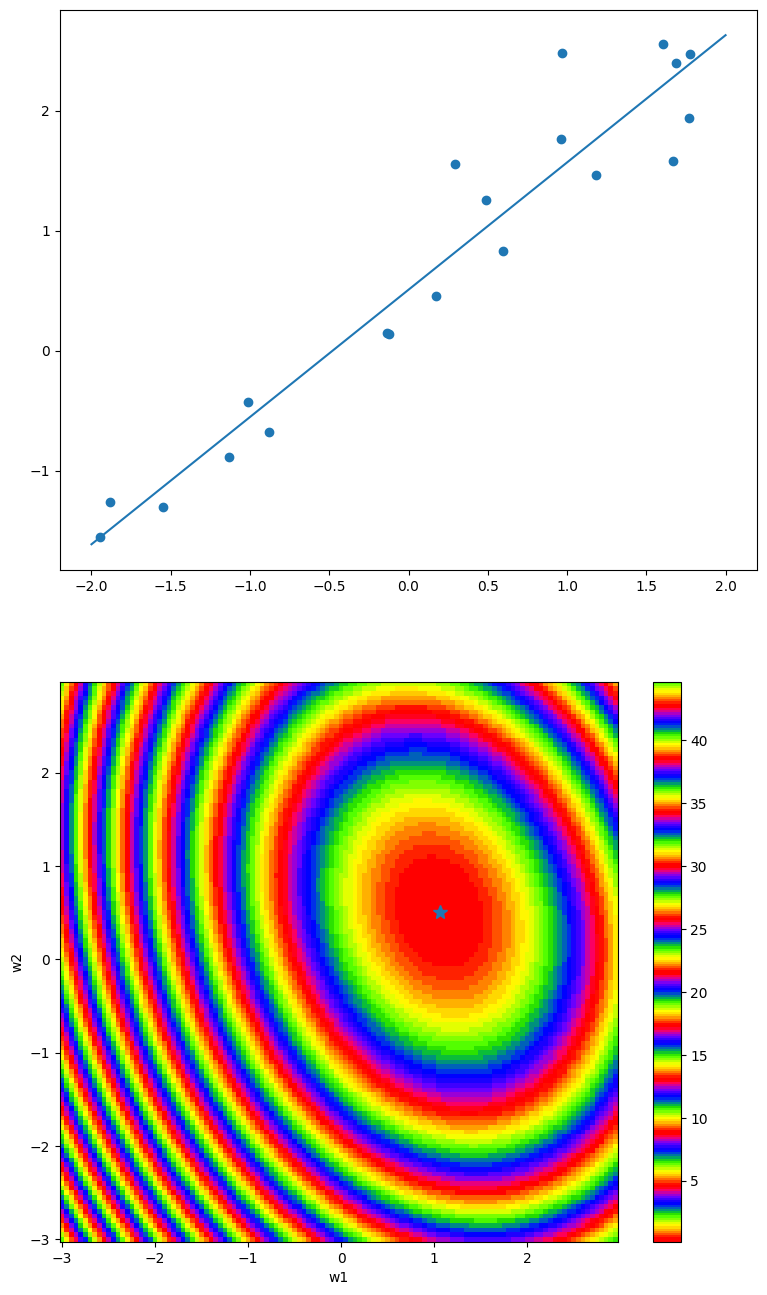

In [7]:
# Display the result of MSEs
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)
plt.plot([xMin, xMax], [w1 * xMin + w2, w1 * xMax + w2])

plt.subplot(2,1,2)
displayError(xs, ys, errorMSE)
plt.plot(w1, w2, "*", markersize = 10)

plt.show()

In [51]:
def swapDictionary(N, B, c_n, c_b, argN, argB):
    for i in range(N.shape[0]):
        tmp = N[i][argN]
        N[i][argN] = B[i][argB]
        B[i][argB] = tmp

    tmp = c_n[argN]
    c_n[argN] = c_b[argB]
    c_b[argB] = tmp

    return N, B, c_n, c_b

# For this function, all elements in b must be positive.
def simplex(c, N, b, originalIndexes = None):
    # Small error must be ignored
    about0 = 1e-8

    c = np.array(c, dtype=float)
    N = np.array(N, dtype=float)
    b = np.array(b, dtype=float)

    # Initialize
    B = np.eye(N.shape[0], dtype=float)
    c_n = np.array(c)
    c_b = np.zeros(N.shape[0], dtype=float)

    if originalIndexes == None:
        indexes = np.arange(np.sum(N.shape))
    else:
        indexes = np.copy(originalIndexes)
        # Swap the dictionary
        originalDict = np.concatenate([N, B], 1)
        originalC = np.concatenate([c_n, c_b])

        dictTmp = np.zeros_like(originalDict)
        cTmp = np.zeros_like(originalC)

        for i, index in enumerate(indexes):
            for j in range(N.shape[0]):
                dictTmp[j][i] = originalDict[j][index]

            cTmp[i] = originalC[index]

        N = dictTmp[:, :N.shape[1]]
        B = dictTmp[:, N.shape[1]:]
        c_n = cTmp[:N.shape[1]]
        c_b = cTmp[N.shape[1]:]

    xsList = []
    zList = []

    # Step 1
    print("B")
    print(B)
    x_b = np.matmul(np.linalg.inv(B), b)
    x_n = np.zeros(N.shape[1])
    
    while True:
        # Here is also Step 1
        bBar = np.matmul(np.linalg.inv(B), b)
        
        # Store the result
        # Here, x = 0 is feasible
        xsTmp = np.concatenate([x_n, x_b])
        # Initialize xsBin
        xsBin = np.arange(indexes.size, dtype = float)
        
        for i in range(indexes.size):
            xsBin[indexes[i]] = xsTmp[i]
        z = np.dot(c, np.array(xsBin[:c.size]))

        xsList.append(xsBin)
        zList.append(z)

        # Step 2
        cnBar = c_n - np.dot(np.matmul(np.transpose(N), np.transpose(np.linalg.inv(B))), c_b)

        # Step 3
        if np.max(cnBar) <= about0:
            break
        
        # Largest coefficient rule (P.39)
        k = np.argmax(cnBar)

        # Step 4
        NBar = np.matmul(np.linalg.inv(B), N)
        aBar = NBar[:,k]

        if np.max(aBar) <= 0:
            zList.append(np.Inf)
            break

        thetaArg = 0
        theta = np.Inf
        for i in range(bBar.size):
            if aBar[i] > about0:
                if (bBar[i] / aBar[i] < theta):
                    thetaArg = i
                    theta = bBar[i] / aBar[i]

        # Step 5
        x_b = bBar - theta * aBar
        x_b[thetaArg] = theta

        N, B, c_n, c_b = swapDictionary(N, B, c_n, c_b, k, thetaArg)

        tmp = indexes[k]
        indexes[k] = indexes[N.shape[1] + thetaArg]
        indexes[N.shape[1] + thetaArg] = tmp

    return zList, xsList


In [9]:
def constructAuxiliaryParam(N, b):
    N = np.array(N)
    b = np.array(b)
    
    # any(b < 0) is true
    auxiliaryK = np.argmin(b)
    rowK = N[auxiliaryK]
    bk = b[auxiliaryK]

    N = N - rowK
    N[auxiliaryK] = -rowK
    N = np.insert(N, rowK.size, -1, axis = 1)

    b = b - bk
    b[auxiliaryK] = -bk
    retC = np.insert(-rowK, rowK.size, -1)
    
    return retC, N, b, bk

In [48]:
def twoPhaseSimplex(c, N, b):
    c = np.array(c, dtype=float)
    N = np.array(N, dtype=float)
    b = np.array(b, dtype=float)

    if all(b >= 0) :
        zList, xsList = simplex(c, N, b)
    else:
        about0 = 1e-8

        cAux, NAux, bAux, bk = constructAuxiliaryParam(N, b)

        zList, xsList = simplex(cAux, NAux, bAux)

        if zList[-1] + bk < -about0:
            print("Infeasible!")
            return None, None
        else:
            xs = np.concatenate([xsList[-1][:N.shape[1]], xsList[-1][(N.shape[1] + 1):]])
    
            indexes = []

            for i, initialValue in enumerate(xs):
                if initialValue <= about0:
                    indexes.append(i)
            for i, initialValue in enumerate(xs):
                if initialValue > about0:
                    indexes.append(i)

            zList, xsList = simplex(c, N, b, indexes)

    return zList, xsList

In [11]:
def formulateMAE(xs, ys):
    # Refer to (2.13)
    # x_n = [a0+, a0-, a1+, a1-, z0, ..., zn] 
    # The object is :
    #     Minimize z1 + ... + zn
    #  This is equivalent to
    #     Maxmize - z1 - ... - zn (Refer to P.26)
    # The constraints are :
    #     yi - ((a0+ - a0-) * xi + (a1+ - a1-) >= -zi
    #     yi - ((a0+ - a0-) * xi + (a1+ - a1-) <= zi
    #  The number of these constrains is 2n
    #  And all elements in x_n are positive.
    #  yi - ((a0+ - a0-) * xi + (a1+ - a1-) >= -zi is equivalent to ((a0+ - a0-) * xi - (a1+ - a1-) - yi <= zi (Refer to P.26)
    #
    # The size of x_n is n + 4
    # The size of B is 2n x 2n
    # The size of N is 2n x (n + 4)
    # The size of B shows that the size of x_b is 2n
    # 
    # Usually, x_n = 0 can not be feasible. It is because the LHS of the constaints can not be 0 because the MAE can not 0 but RHS is 0 when x_n = 0.
    # This requires two-phase simplex methods.

    dataNum = xs.size

    c = np.array([0, 0, 0, 0], dtype=float)
    cForZ = -np.ones(dataNum)
    c = np.concatenate([c, cForZ])

    N = []
    b = []

    for i in range(dataNum):
        subN0 = [xs[i], -xs[i], -1, 1]
        subN1 = [-xs[i], xs[i], 1, -1]

        for j in range(dataNum):
            if i == j:
                subN0.append(-1)
                subN1.append(-1)
            else:
                subN0.append(0)
                subN1.append(0)

        N.append(subN0)
        N.append(subN1)

        b.append(ys[i])
        b.append(-ys[i])

    return c, np.array(N, dtype=float), np.array(b, dtype=float)

In [52]:
c, N, b = formulateMAE(xs, ys)
about0 = 1e-8

zList, xsList = twoPhaseSimplex(c, N, b)

a = []
b = []

np.set_printoptions(linewidth=10000)
print(zList)
for point in xsList:
    print(point)
    if point[0] < about0:
        a.append(-point[1])
    else:
        a.append(point[0])

    if point[2] < about0:
        b.append(point[3])
    else:
        b.append(-point[2])

B
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
B
[[ 0.          0.          0.49160678 ...  0.          0.          0.        ]
 [ 0.          0.         -0.49160678 ...  0.          0.          0.        ]
 [ 0.          0.          0.96714796 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.88207054 ...  0.          1.          0.        ]
 [ 0.          1.          1.66538149 ...  0.          0.          0.        ]
 [ 0.          0.         -1.66538149 ...  0.          0.          1.        ]]


LinAlgError: Singular matrix

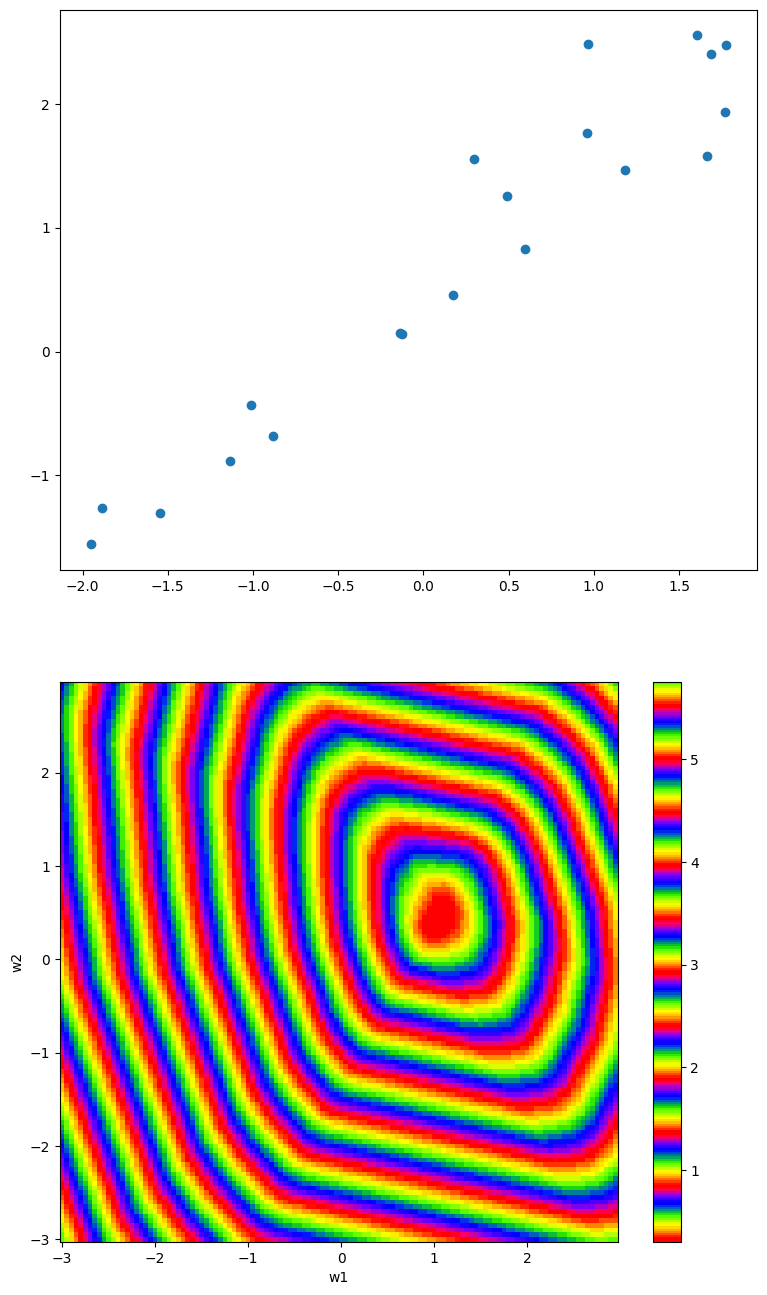

In [12]:
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)

plt.subplot(2,1,2)
displayError(xs, ys, errorMAE)

plt.show()

In [13]:
def formulateME(xs, ys):
    # Refer to (2.18)
    # x_n = [a0+, a0-, a1+, a1-, z] 
    # The object is :
    #     Minimize z
    #  This is equivalent to
    #     Maxmize -z(Refer to P.26)
    # The constraints are :
    #     yi - ((a0+ - a0-) * xi + (a1+ - a1-) >= -z
    #     yi - ((a0+ - a0-) * xi + (a1+ - a1-) <= z
    #  The number of these constrains is 2n
    #  And all elements in x_n are positive.
    #  yi - ((a0+ - a0-) * xi + (a1+ - a1-) >= -z is equivalent to ((a0+ - a0-) * xi - (a1+ - a1-) - yi <= z (Refer to P.26)
    #
    # The size of x_n is 5
    # The size of B is 2n x 2n
    # The size of N is 2n x 5
    # The size of B shows that the size of x_b is 2n
    # 
    # Usually, x_n = 0 can not be feasible. It is because the LHS of the constaints can not be 0 because the MAE can not 0 but RHS is 0 when x_n = 0.
    # This requires two-phase simplex methods.

    dataNum = xs.size

    c = np.array([0, 0, 0, 0, -1], dtype=float)

    N = []
    b = []

    for i in range(dataNum):
        N.append([xs[i], -xs[i], -1, 1, -1])
        N.append([-xs[i], xs[i], 1, -1, -1])

        b.append(ys[i])
        b.append(-ys[i])

    return c, np.array(N, dtype=float), np.array(b, dtype=float)

In [44]:
c, N, b = formulateME(xs, ys)
about0 = 1e-8

print(c)
print(N)
print(b)

zList, xsList = twoPhaseSimplex(c, N, b)

a = []
b = []

np.set_printoptions(linewidth=10000)
print(zList)
for point in xsList:
    print(point)
    if point[0] < about0:
        a.append(-point[1])
    else:
        a.append(point[0])

    if point[2] < about0:
        b.append(point[3])
    else:
        b.append(-point[2])


[ 0.  0.  0.  0. -1.]
[[ 0.49160678 -0.49160678 -1.          1.         -1.        ]
 [-0.49160678  0.49160678  1.         -1.         -1.        ]
 [ 0.96714796 -0.96714796 -1.          1.         -1.        ]
 [-0.96714796  0.96714796  1.         -1.         -1.        ]
 [ 1.18077426 -1.18077426 -1.          1.         -1.        ]
 [-1.18077426  1.18077426  1.         -1.         -1.        ]
 [ 1.76980114 -1.76980114 -1.          1.         -1.        ]
 [-1.76980114  1.76980114  1.         -1.         -1.        ]
 [ 0.9595943  -0.9595943  -1.          1.         -1.        ]
 [-0.9595943   0.9595943   1.         -1.         -1.        ]
 [ 1.68929999 -1.68929999 -1.          1.         -1.        ]
 [-1.68929999  1.68929999  1.         -1.         -1.        ]
 [-1.88397909  1.88397909 -1.          1.         -1.        ]
 [ 1.88397909 -1.88397909  1.         -1.         -1.        ]
 [-0.13750938  0.13750938 -1.          1.         -1.        ]
 [ 0.13750938 -0.13750938  1.    

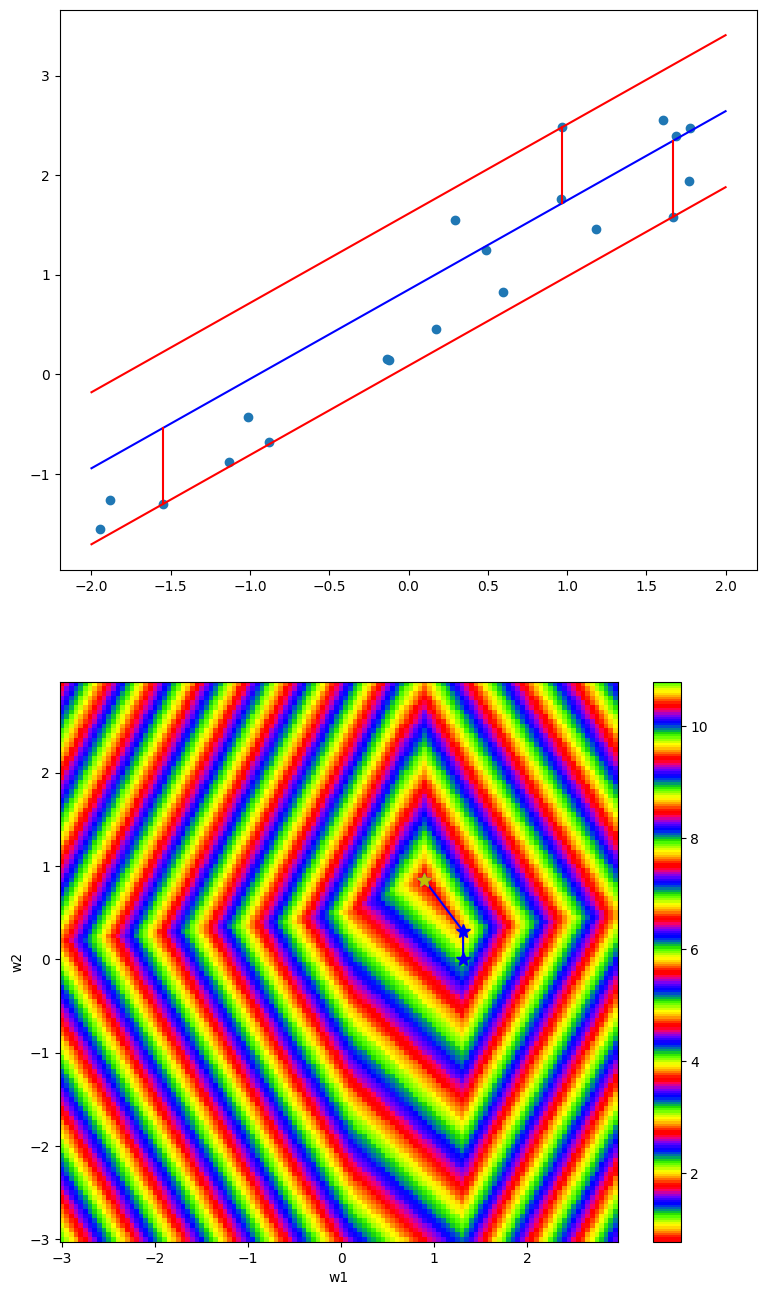

In [42]:
fig = plt.figure(figsize=(9,16))

plt.subplot(2,1,1)
plt.scatter(xs, ys)
plt.plot([xMin, xMax], [a[-1] * xMin + b[-1], a[-1] * xMax + b[-1]], color = "b")
plt.plot([xMin, xMax], [a[-1] * xMin + b[-1] + zList[-1], a[-1] * xMax + b[-1] + zList[-1]], color = "r")
plt.plot([xMin, xMax], [a[-1] * xMin + b[-1] - zList[-1], a[-1] * xMax + b[-1] - zList[-1]], color = "r")

for x, y in zip(xs, ys):
    absValue = np.abs(y - (a[-1] * x + b[-1]))
    #print("(", x, ", ", y, ") : ", absValue)
    if np.abs(absValue + zList[-1]) < about0:
        plt.plot([x, x], [y, a[-1] * x + b[-1]], color = "r")

plt.subplot(2,1,2)
displayError(xs, ys, errorME)

plt.plot(a, b, marker = "*", color = "b", markersize = 10)
plt.plot(a[-1], b[-1], marker = "*", color = "y", markersize = 10)

plt.show()



In [16]:
# Solve the optimization problem shown in (2.37)
# Object function : maximize x1 + 2 x2
# constraint :
#   x1 + x2 <= 6
#   x1 + 3 x2 <= 12
#   2 x1 + x2 <= 10
#   all variables (x1, x2) are positive

# Input values
# Variable names are defined refering section 2.2.4
c = [1, 2] # This is a row vector!!
N = [[1, 1], [1, 3], [2, 1]]
b = [6, 12, 10] # This is alse a row vector!!

# Here, c.size must be the same with N.shape[1]
# b.size must be the same with N.shape[0]
# They are not checked here. 

x1Min = -6.0
x1Max = 6.0
x2Min = -6.0
x2Max = 6.0
xStep = 0.05


In [17]:
def solveSimplex(c, N, b):
    zList, xsList = twoPhaseSimplex(c, N, b)
    print(zList)
    print(xsList)

    unboundedFlag = (len(zList) != len(xsList))
    if unboundedFlag:
        print("Unbounded!!")
        updatedPointNum = len(xsList)
    else:
        updatedPointNum = len(xsList) - 1

    x1s = np.arange(x1Min, x1Max, xStep)
    x2s = np.arange(x2Min, x2Max, xStep)

    X1, X2 = np.meshgrid(x1s, x2s)
    zs = np.dot(np.array([X1, X2]).transpose(1, 2, 0), c)

    fig = plt.figure(figsize=(20,16))
    plt.pcolormesh(X1, X2, zs)

    pp=plt.colorbar (orientation="vertical")

    plt.xlabel('x1', fontsize=10)
    plt.ylabel('x2', fontsize=10)

    plt.plot([0, x1Max], [0, 0], color = "b")
    plt.plot([0, 0], [0, x2Max], color = "b")
    plt.xlim([x1Min, x1Max])
    plt.ylim([x2Min, x2Max])

    for n, bElem in zip(N, b):
        a1 = - n[0] / n[1]
        a2 = bElem / n[1]
        x1Points = np.array([x1Min, x1Max])
        plt.plot(x1Points, a1 * x1Points + a2, color = "g")

    if not  unboundedFlag:
        plt.plot(xsList[-1][0], xsList[-1][1], marker='.', markersize = 10, color = "r")
        plt.text(xsList[-1][0], xsList[-1][1], "({} : z = {} : xs = {})".format(len(zList) - 1, zList[-1], xsList[-1]), size = 10)
        plt.plot(x1Points, -c[0] / c[1] * x1Points + zList[-1] / c[1], color = "r")

    for i in range(updatedPointNum):
        plt.plot(xsList[i][0], xsList[i][1], marker='.', markersize = 10, color = "b")
        plt.text(xsList[i][0], xsList[i][1], "({} : z = {} : xs = {})".format(i, zList[i], xsList[i]), size = 10)

    plt.show()


[0.0, 8.0, 9.0]
[array([ 0.,  0.,  6., 12., 10.]), array([0., 4., 2., 0., 6.]), array([3., 3., 0., 0., 1.])]


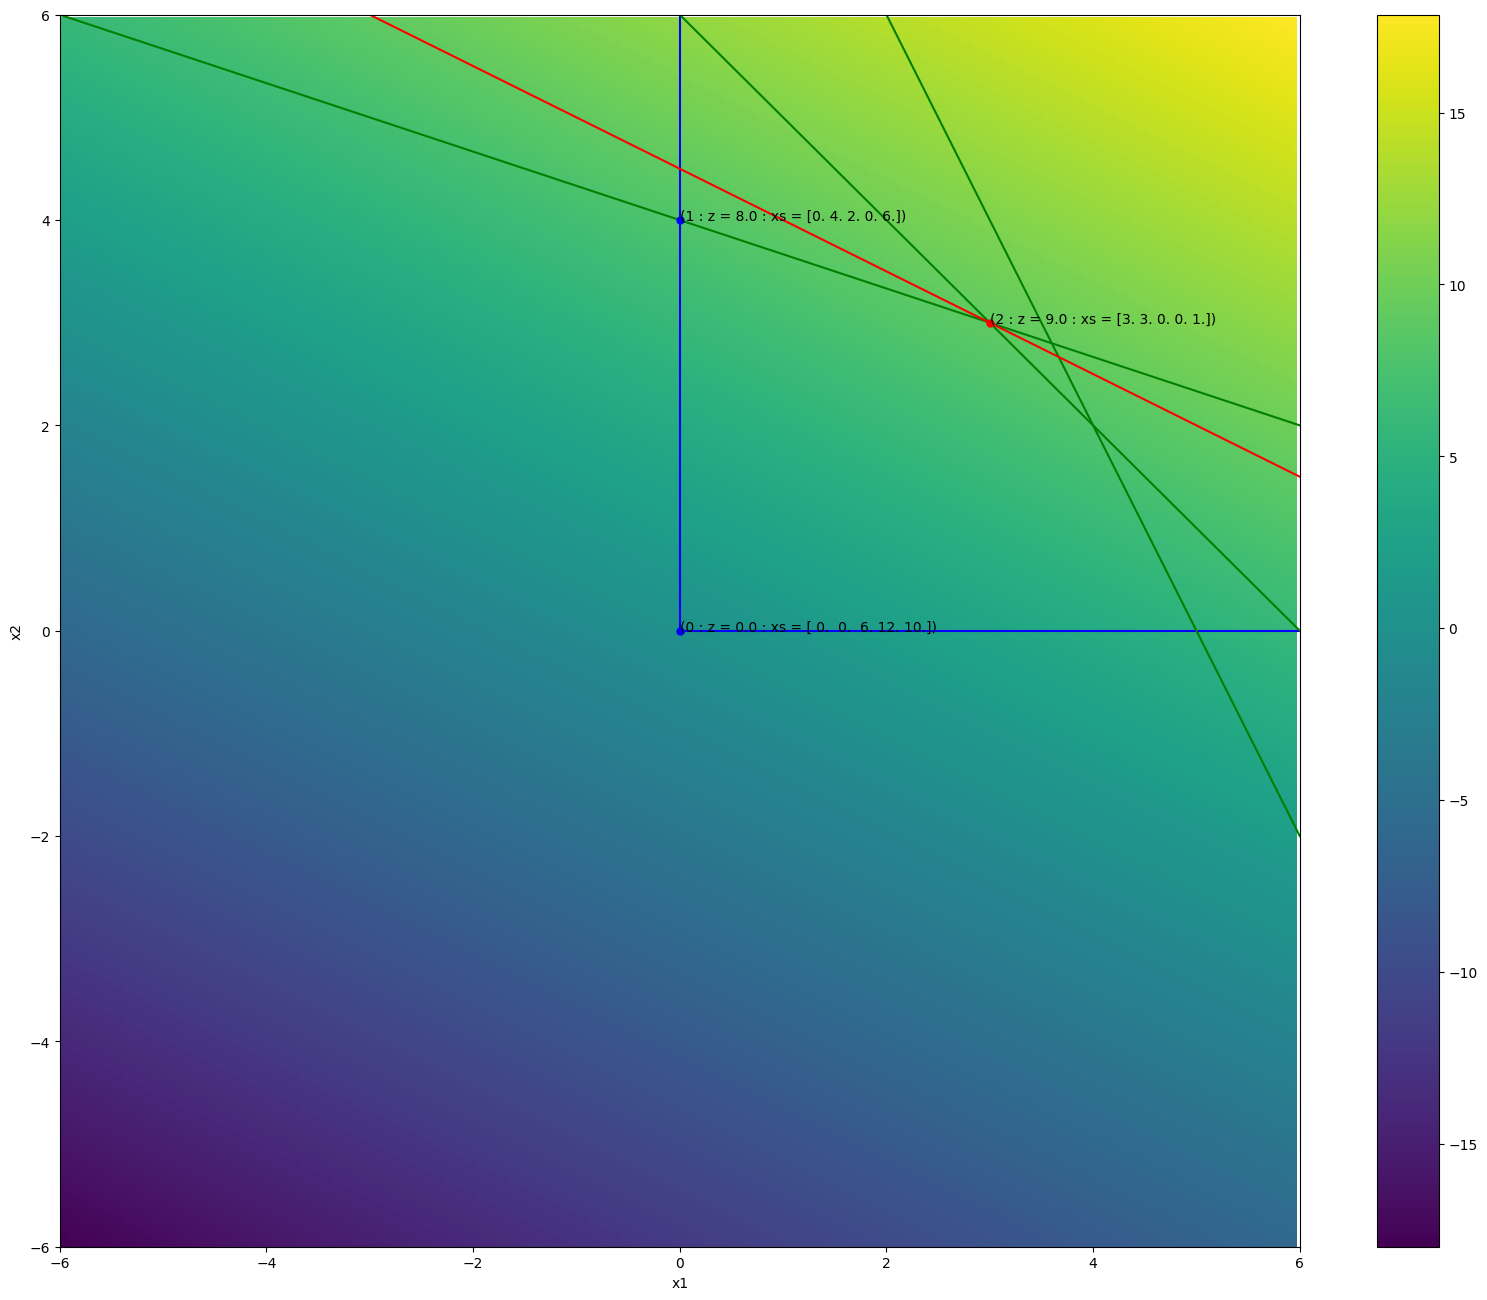

In [18]:
solveSimplex(c, N, b)

[0.0, 8.0, inf]
[array([0., 0., 4., 2.]), array([4., 0., 0., 6.])]
Unbounded!!


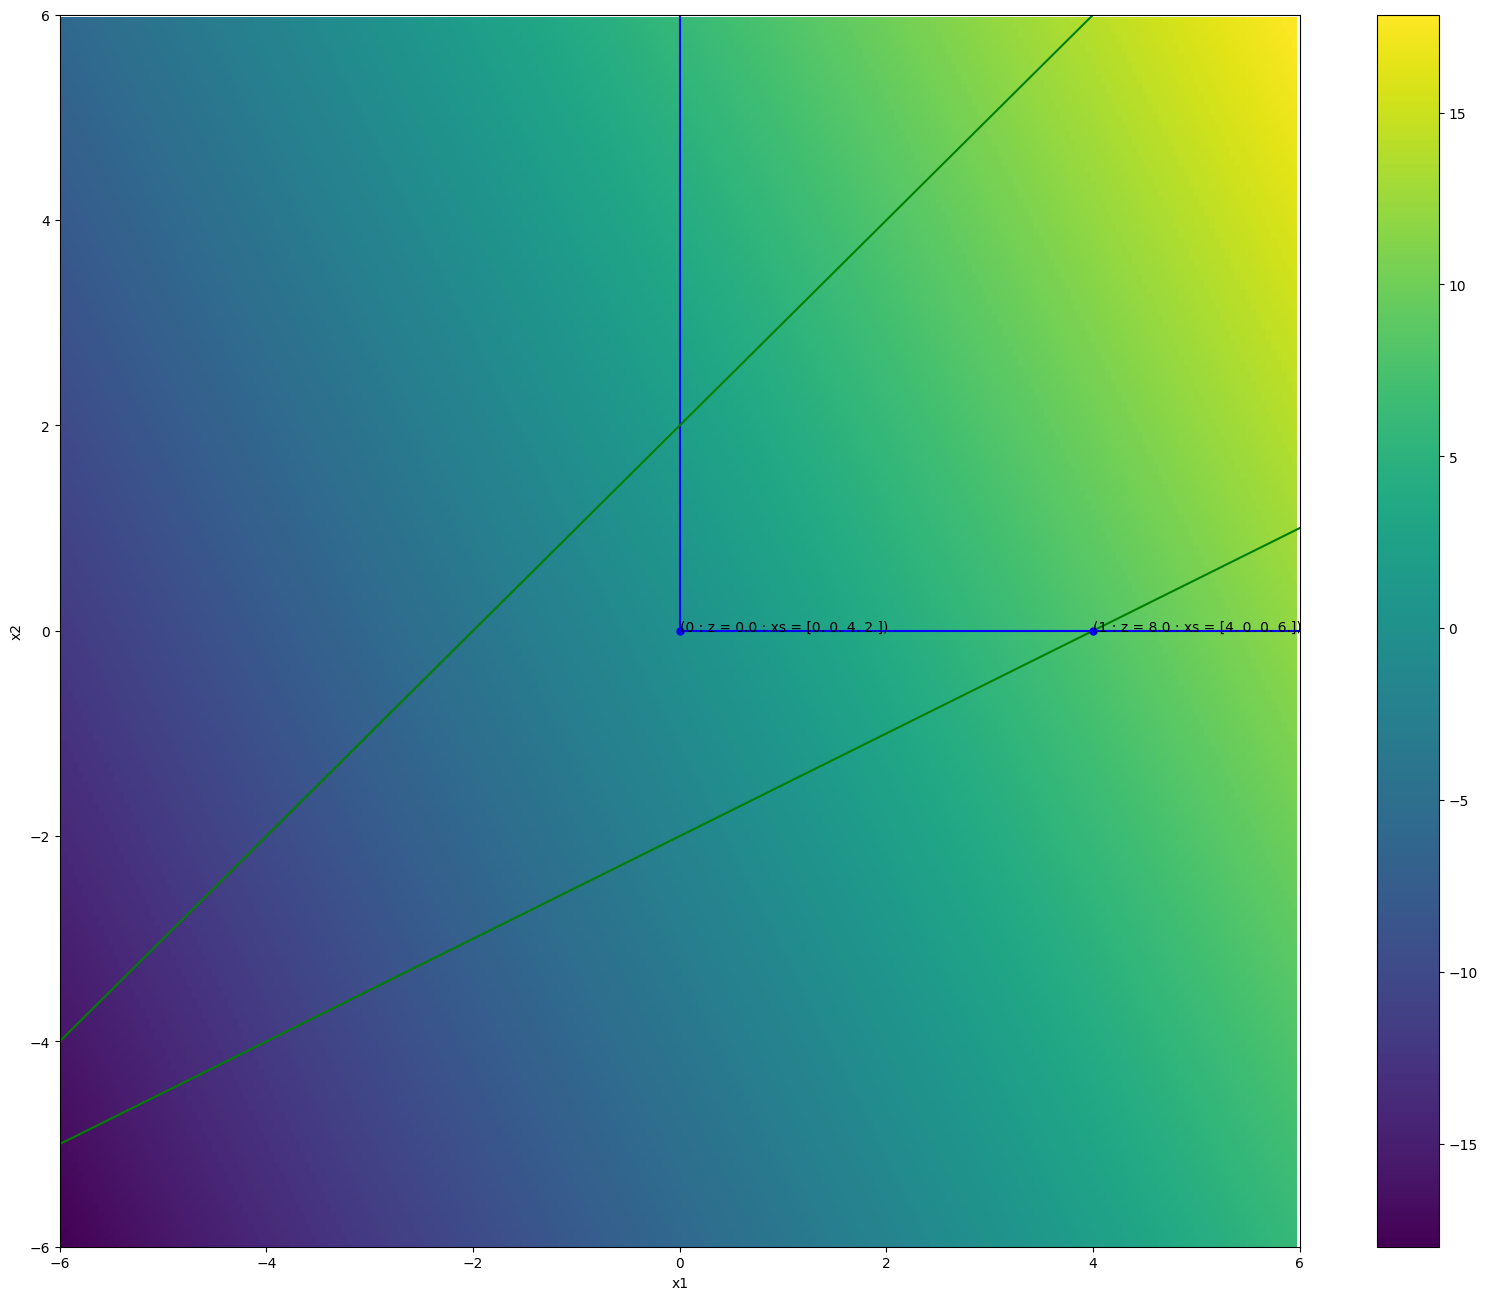

In [19]:
# Solve the optimization problem shown in (2.47)
# Object function : maximize 2 x1 + x2
# constraint :
#   x1 - 2 x2 <= 4
#   -x1 + x2 <= 2
#   all variables (x1, x2) are positive

# Input values
# Variable names are defined refering section 2.2.4
c = [2, 1]
N = [[1, -2], [-1, 1]]
b = [4, 2] 

solveSimplex(c, N, b)

[0.0, 9.0, 9.0]
[array([0., 0., 6., 3.]), array([3., 0., 0., 0.]), array([3., 0., 0., 0.])]


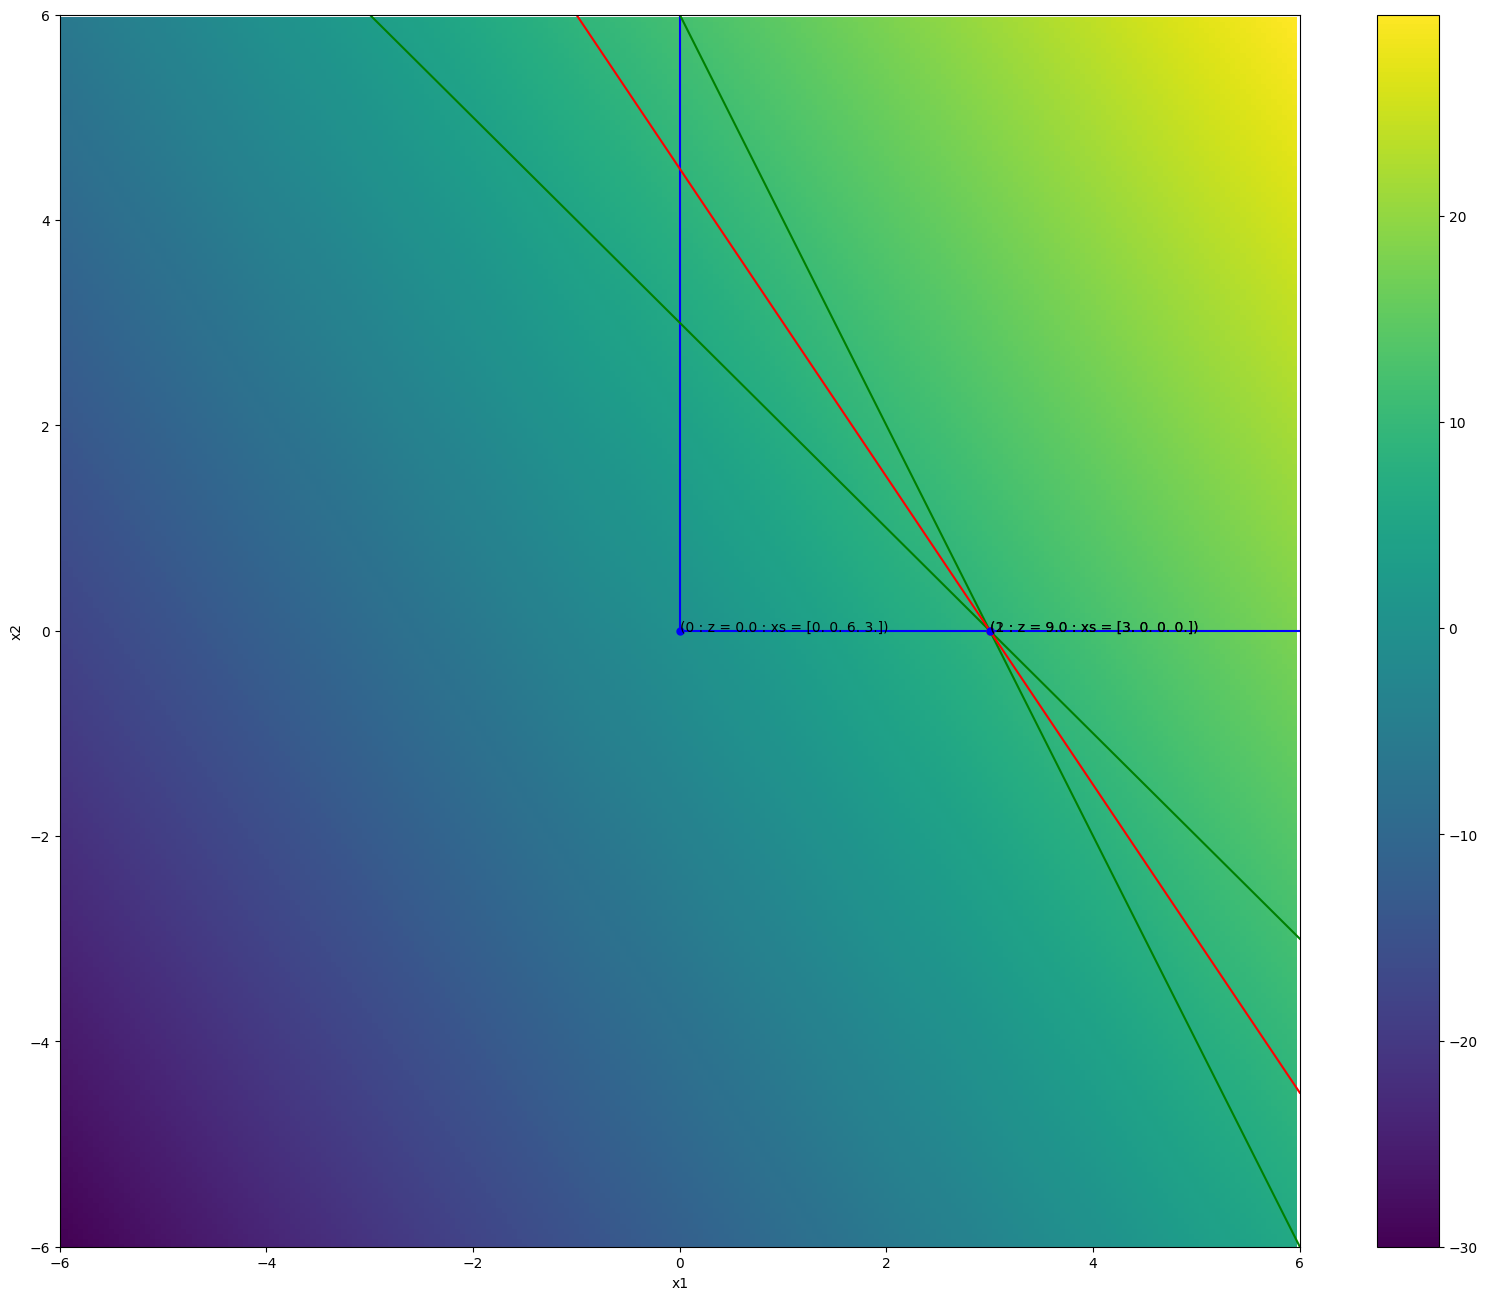

In [20]:
# Solve the optimization problem shown in (2.64)
# Object function : maximize 3 x1 + 2 x2
# constraint :
#   2 x1 + x2 <= 6
#   x1 + x2 <= 3
#   all variables (x1, x2) are positive

# Input values
# Variable names are defined refering section 2.2.4
c = [3, 2]
N = [[2, 1], [1, 1]]
b = [6, 3] 

solveSimplex(c, N, b)

[2.0, 6.0, 8.0, 9.0]
[array([ 2.,  0.,  4., 10.,  0.]), array([0., 3., 3., 3., 0.]), array([0., 4., 2., 0., 2.]), array([3., 3., 0., 0., 9.])]


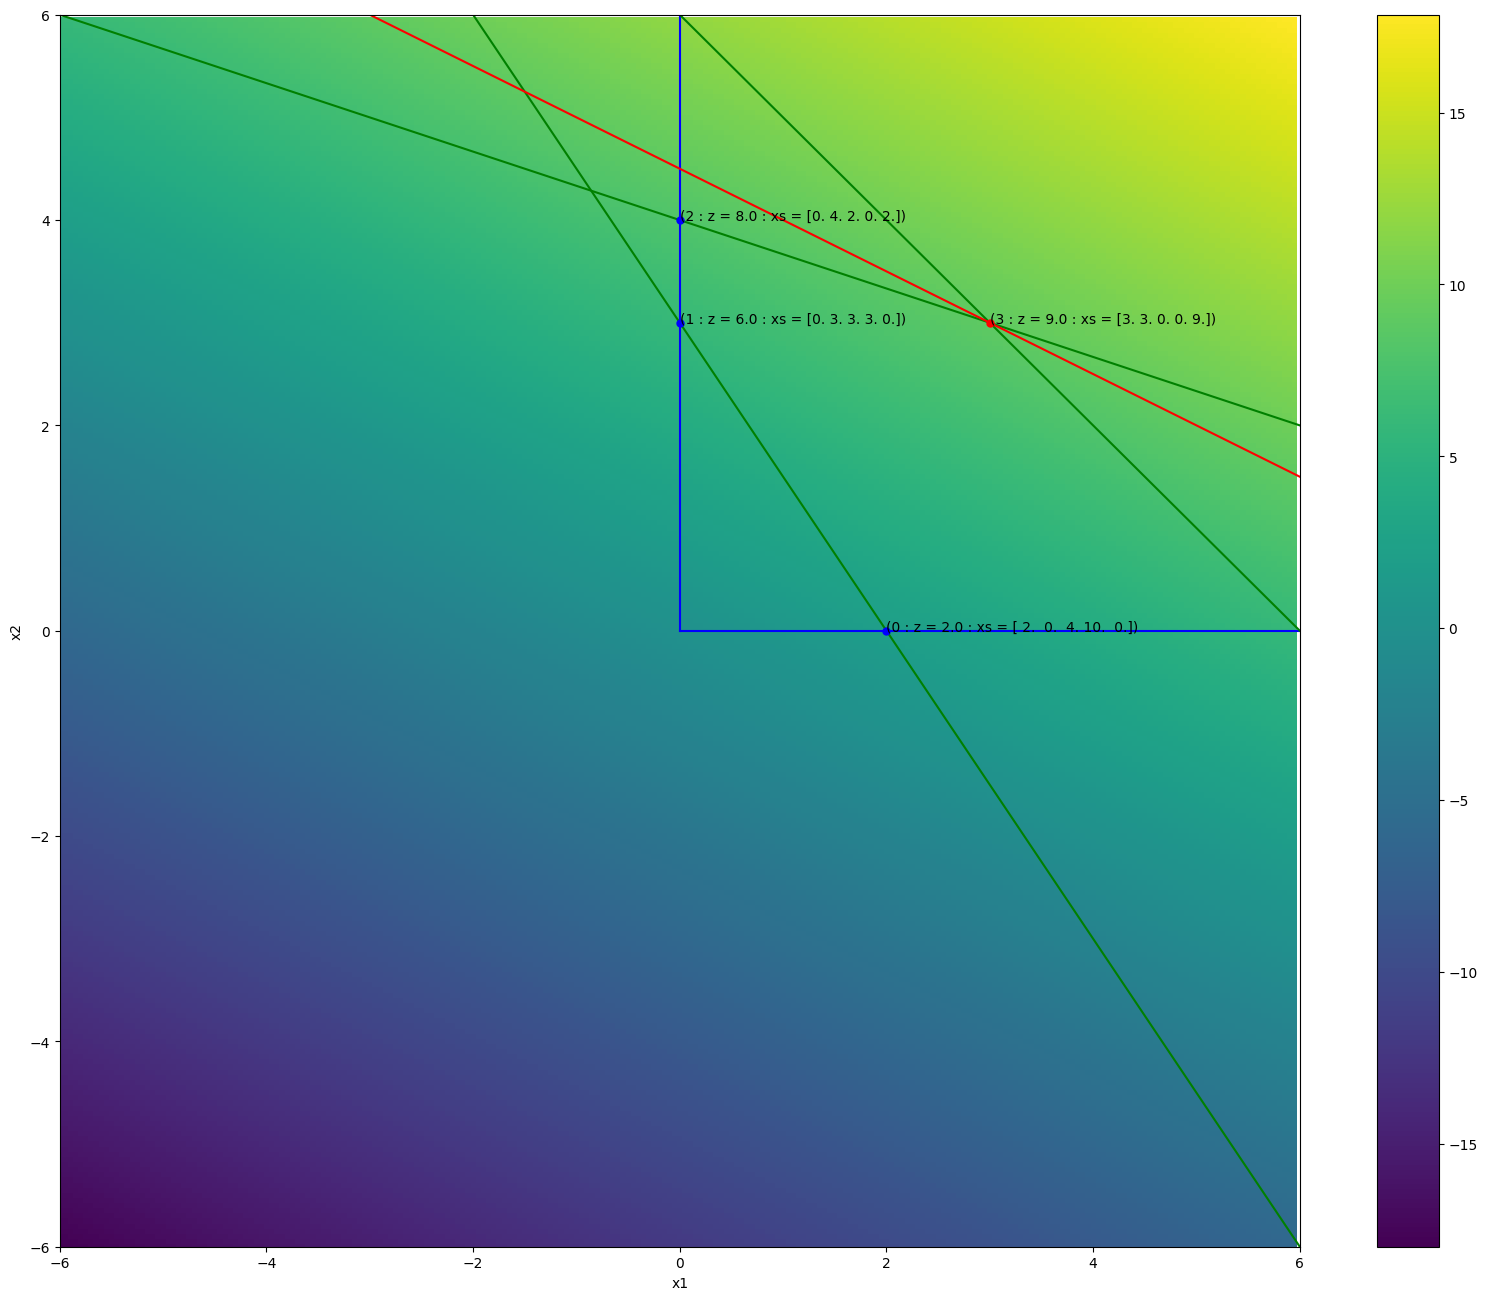

In [22]:
originalC = [1, 2]
originalN = [[1, 1], [1, 3], [-3, -2]]
originalb = [6, 12, -6]

zList, xsList = twoPhaseSimplex(originalC, originalN, originalb)

solveSimplex(originalC, originalN, originalb)